Detect and calculate the durations of outages using spike detection.

In [11]:
import math
from pathlib import Path
import os
import gc

import pandas as pd
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.filtertools import convolution_filter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
gc.enable()
sns.set_palette("Set2")

# HOME = Path(os.environ['HOME'])
HOME = Path("/notebooks")
# HOME = Path("/mnt/c/Users/isabe")
# PROJECT = HOME / "Documents/repos/eagle-comp"
PROJECT = HOME / "eagle-comp"
DATA = PROJECT / "data"
EAGLE_DATA = Path("/datasets/eagle-comp")

In [3]:
def add_zeroes(outage_df):
    outage_df = outage_df.reset_index()
    outage_df['run_start_time'] = pd.to_datetime(outage_df['run_start_time'])
    outage_df['run_start_time'] = outage_df['run_start_time'].dt.round('15min')
    outage_df = outage_df.set_index(["fips_code", "run_start_time"]).sort_index()
    na_rows = outage_df[outage_df['sum'].isna()].index
    outage_df = outage_df.groupby('fips_code').apply(lambda g: g.loc[g.index.get_level_values(0)[0]].resample('15T').mean().fillna(0))
    outage_df.loc[na_rows] = np.nan
    outage_df.reset_index(inplace=True)
    return outage_df

In [4]:
outages_2022 = pd.read_csv(EAGLE_DATA / f"eaglei_outages_2022.csv", parse_dates=['run_start_time'], index_col=['fips_code', 'run_start_time'])
counties_states = outages_2022.reset_index().set_index("fips_code")[["county", "state"]].drop_duplicates().sort_index()
outages_2022 = add_zeroes(outages_2022[["sum"]])#.pivot_table(index="run_start_time", columns="fips_code", values="sum")
outages_2022 = outages_2022.set_index(["fips_code", "run_start_time"]).sort_index()

In [5]:
# from https://www.statsmodels.org/stable/_modules/statsmodels/tsa/seasonal.html#seasonal_decompose
nsides = 2
period = 16
if period % 2 == 0:  # split weights at ends
    filt = np.array([0.5] + [1] * (period - 1) + [0.5]) / period
else:
    filt = np.repeat(1.0 / period, period)
outages_2022["trend"] = convolution_filter(outages_2022.interpolate(), filt, nsides)

In [6]:
def per_fips_code(df, func):
    return df.groupby("fips_code").transform(func)

In [7]:
# Threshold is from https://direct.mit.edu/neco/article-abstract/16/8/1661/6903/Unsupervised-Spike-Detection-and-Sorting-with?redirectedFrom=fulltext
outages_2022["threshold"] = per_fips_code(outages_2022["trend"], lambda trend: 4 * (trend / 0.6745).median())
outages_2022["is_outage"] = (outages_2022["trend"] > outages_2022["threshold"]) | (outages_2022["sum"] > outages_2022["threshold"])

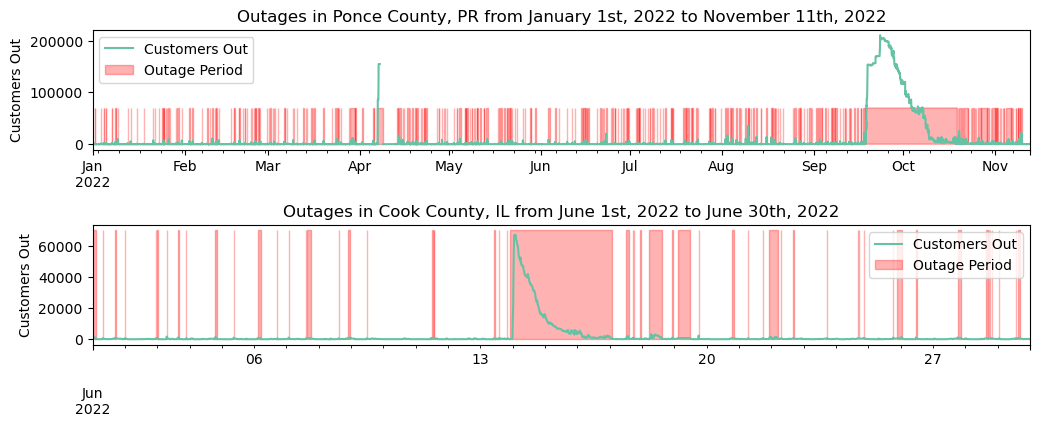

In [12]:
fips = 17031
fig, ax = plt.subplots(2, 1, figsize=(12/8 *7, 5/8 *7))
outages_2022.loc[fips, 'sum'].plot(ax=ax[1])
outage_period = outages_2022.loc[fips, 'is_outage']
ax[1].fill_between(outage_period.index, 0, 70000, where=outage_period, color='red', alpha=0.3)
ax[1].set_xlim(pd.to_datetime('2022-06-01'), pd.to_datetime('2022-06-30'))
ax[1].set_title('Outages in Cook County, IL from June 1st, 2022 to June 30th, 2022')
ax[1].set_ylabel('Customers Out')
ax[1].set_xlabel("")
ax[1].legend(['Customers Out', 'Outage Period'])
# plt.ylim(0, 10000)
fips = 72113
outages_2022.loc[fips, 'sum'].plot(ax=ax[0])
outage_period = outages_2022.loc[fips, 'is_outage']
ax[0].fill_between(outage_period.index, 0, 70000, where=outage_period, color='red', alpha=0.3)
# ax[1].set_xlim(pd.to_datetime('2022-01-01'), pd.to_datetime('2022-12-31'))
ax[0].set_title('Outages in Ponce County, PR from January 1st, 2022 to November 11th, 2022')
ax[0].set_ylabel('Customers Out')
ax[0].set_xlabel("")
ax[0].legend(['Customers Out', 'Outage Period'])
plt.tight_layout()
plt.show()
# ax[1].set_ylabel([])
# plt.ylim(0, 10000)

In [13]:
# If RAM Is a problem, drop these columns
outages_2022.drop(columns=["trend", "threshold"], inplace=True)
gc.collect()

80

In [15]:
outages_2022["outage_started"] = per_fips_code(outages_2022["is_outage"], lambda x: x.astype(int).diff() == 1)
outages_2022["outage_ended"] = per_fips_code(outages_2022["is_outage"], lambda x: x.astype(int).diff() == -1)

In [17]:
# outages_2022["outaged_started"] = outages_2022["is_outage"].astype(int).diff() == 1
# outages_2022["outaged_ended"] = outages_2022["is_outage"].astype(int).diff() == -1
def get_outage_durations(county_outages):
    county_outages = county_outages.loc[county_outages.index.get_level_values(0)[0]]
    start_times = county_outages[county_outages["outage_started"]].index
    end_times = county_outages[county_outages["outage_ended"]].index
    if start_times.shape[0] <= 1 or end_times.shape[0] <= 1:
        return county_outages
    if start_times[0] > end_times[0]:
        county_outages.loc[end_times[0], 'outage_ended'] = False
        end_times = end_times[1:]
    if start_times[-1] > end_times[-1]:
        county_outages.loc[start_times[-1], 'outage_started'] = False
        start_times = start_times[:-1]
    # if start_times.shape[0] > end_times.shape[0]:
    #     county_outages.loc[start_times[-1], 'outage_started'] = False
    #     start_times = start_times[:-1]
    # if start_times.shape[0] < end_times.shape[0]:
    #     county_outages.loc[end_times[0], 'outage_ended'] = False
    #     end_times = end_times[1:]
    county_outages.loc[start_times, 'duration'] = end_times - start_times
    county_outages['duration'] = county_outages['duration'].fillna(method="ffill")
    county_outages.loc[~county_outages['is_outage'], 'duration'] = np.nan
    county_outages['duration'] = county_outages['duration'].astype('timedelta64[m]')
    county_outages['outage_id'] = county_outages['outage_started'].cumsum()
    county_outages['outage_id'] = county_outages['outage_id'].fillna(method='ffill')
    county_outages.loc[~county_outages['is_outage'], 'outage_id'] = np.nan
    # return end_times - start_times
    return county_outages
# durations = outages_2022[["outage_started", "outage_ended"]].groupby("fips_code").apply(get_outage_durations)
outages_2022 = outages_2022.groupby("fips_code").apply(get_outage_durations)

In [18]:
outages_2022[outages_2022['is_outage'].isna()] = False

In [20]:
outages_2022['duration'].value_counts()

15.0      1445545
30.0       777028
300.0      719783
315.0      678850
330.0      676108
           ...   
7395.0        493
7365.0        491
7290.0        486
7125.0        475
5610.0        374
Name: duration, Length: 1729, dtype: int64

In [25]:
# Look at peak customers out for each outage for each county
outages_2022.groupby(['fips_code', 'outage_id']).max()

sum  is_outage  outage_started  outage_ended  \
fips_code outage_id                                                     
1001      1.0           14.0       True            True         False   
          2.0           30.0       True            True         False   
          3.0            9.0       True            True         False   
          4.0          723.0       True            True         False   
          5.0           25.0       True            True         False   
...                      ...        ...             ...           ...   
78030     398.0         30.0       True            True         False   
          399.0         27.0       True            True         False   
          400.0       3701.0       True            True         False   
          401.0      10409.0       True            True         False   
          402.0         40.0       True            True         False   

                     duration  
fips_code outage_id            
1001      1.0           180.0  
          2.0           375.0  
          3.0           195.0  
          4.0          1320.0  
          5.0           255.0  
...                       ...  
78030     398.0          15.0  
          399.0          15.0  
          400.0         525.0  
          401.0         750.0  
          402.0         420.0  

[2853511 rows x 5 columns]

In [ ]:
outages_2022.to_csv('outages_duration_2022.csv')

In [ ]:
outages_2022 = pd.read_csv('outages_duration_2022.csv', parse_dates=True)

In [ ]:
outages_2022['fips_code'] = outages_2022['fips_code'].astype(int)
outages_2022['run_start_time'] = pd.to_datetime(outages_2022['run_start_time'])
outages_2022.set_index(["fips_code", "run_start_time"], inplace=True)
outages_2022.sort_index(inplace=True)